In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time
from scipy.optimize import minimize
from climin.util import optimizer
import theano
import theano.tensor as T
from itertools import izip, cycle, imap, repeat, islice
from pprint import pprint
from functools import partial

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from schlichtanders.myfunctools import compose, summap, meanmap
from schlichtanders.mygenerators import chunk, every

In [4]:
from theano_models import Merge, fix_params, normalizing_flow, variational_bayes, Reparameterize, Flatten, check_all_identities
from theano_models.tools import as_tensor_variable, softplus, softplus_inv, squareplus, squareplus_inv, L1
                           
import theano_models.postmaps as post
import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Deterministic Model - one dimensional

## target

In [ ]:
target = dm.RadialTransform(init_alpha=1, init_beta=20, init_z0=[3])

In [ ]:
f_target = target.function()
example_target = [7]
f_target(example_target)  # caution, needs vector not scalar input

In [ ]:
N = 40
xs = np.linspace(-10, 10, N)[:, np.newaxis]
xs[:7]

In [ ]:
ys = np.array([f_target(x) for x in xs])
ys[:7]

## model

In [ ]:
model_ = dm.RadialTransform(input=xs[0])
model_

TODO softplus gives immediate precision loss, while e.g. squarepos works like a charm

    # model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), 'parameters')

In [ ]:
model = Merge(model_, Reparameterize(model_['parameters_positive'], squareplus, squareplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

## visualization

In [ ]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear() # interactive
    # target data:
    ax.plot(xs, ys, 'k:')
    
    # model:
    f_model = model.function(givens=givens)
    model_ys = np.array([f_model(x) for x in xs])
    ax.plot(xs, model_ys, 'r')
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
postmap = compose(post.scipy_postmap, post.flat_numericalize_postmap, post.deterministic_optimizer_postmap)
scipy_kwargs = postmap(model, mapreduce=summap)
scipy_kwargs

In [ ]:
fit = minimize(
    args=(ys,xs),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}),
    **scipy_kwargs
); fit

Fix fitted parameters into model.

We need to further build a givens dictionary supply the input-info which usually is given when used as theano.function(model['inputs'], model['outputs']).

In [ ]:
fit.x

In [ ]:
model['flat'] = fit.x

In [ ]:
[(p.name, p.eval()) for p in model_['parameters_positive']]

In [ ]:
[(p.name, p.eval()) for p in model_['parameters']]

# two dimensions

## target

In [ ]:
target2d = dm.RadialTransform(init_alpha=1, init_beta=5, init_z0=[3, 1])
# target2d = dm.RadialTransform(init_alpha=50, init_beta=-40, init_z0=[3, 1])

In [ ]:
f_target2d = target2d.function()
example_target2d = [7, 4]
f_target2d(example_target2d)  # caution, needs vector not scalar input

In [ ]:
N2d = 10
_xs = np.linspace(-10, 10, N2d)
X1, X2 = np.meshgrid(_xs, _xs)
xs2d = np.c_[X1.flat, X2.flat]
xs2d[:5]

In [ ]:
ys2d = np.array([f_target2d(x) for x in xs2d])
ys2d[:5]

## model

In [ ]:
model2d = dm.RadialTransform(input=xs2d[0])
model2d

In [ ]:
model2d = Merge(model2d, Reparameterize(model2d['parameters_positive'], squareplus, squareplus_inv))
model2d = Merge(model2d, Flatten(model2d['parameters']))
model2d

## visualization

In [ ]:
diff2d = ys2d - xs2d
quiver_kwargs = dict(scale=1, angles='xy', scale_units='xy', width=0.003)

def plot_fit2d(fig, ax, givens={}, time_delay=0.1, expand_factor=0.4):
    ax.clear()
    
    # target data:
    ax.quiver(xs2d[:,0], xs2d[:,1], diff2d[:,0], diff2d[:,1], hatch='***', facecolor='none', color="k", **quiver_kwargs)
    
    # model:
    f_model2d = model2d.function(givens=givens)
    m_ys2d = np.array([f_model2d(x) for x in xs2d])
    m_diff2d = m_ys2d - xs2d
    ax.quiver(xs2d[:,0], xs2d[:,1], m_diff2d[:,0], m_diff2d[:,1], color="r", **quiver_kwargs)

    # ax.autoscale()  # does not work with arrows, do it manually:
    l, r, b, t = ax.axis()
    dx, dy = r - l, t - b
    ax.axis([l - expand_factor * dx, r + expand_factor * dx, b - expand_factor * dy, t + expand_factor * dy])
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit2d(fig, ax)

## fit

In [ ]:
postmap = compose(post.scipy_postmap, post.flat_numericalize_postmap, post.deterministic_optimizer_postmap)
scipy_kwargs2d = postmap(model2d, mapreduce=summap)
scipy_kwargs2d

In [ ]:
fit = minimize(
    args=(ys2d,xs2d),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda params: plot_fit2d(fig, ax, {model2d['flat']:params}),
    **scipy_kwargs2d
); fit

# Probabilistic Normalizing Flow

Only the combination with gaussian base function is shown. The uniform base function has the disadvantage of not being differentiable (not yet supported).

## model

In [ ]:
base_model = pm.DiagGauss(output_size=2)
# CAUTION, this transform cannot be reused elsewhere, as it is merged into normalizing flow
# its references point always to the current substitution
transform_model = dm.RadialTransform()

In [ ]:
model = normalizing_flow(transform_model, base_model)
model

In [ ]:
# model.map('parameters_positive',reparameterize_map(squareplus, squareplus_inv), 'parameters')
model = Merge(model, Reparameterize(model['parameters_positive'],softplus, softplus_inv))
model = Merge(model,Flatten(model['parameters']))
model

## target

In [ ]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
transform_target = dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)

In [ ]:
target = normalizing_flow(transform_target, base_target)
t_sampler = target.function()
t_sampler()

In [ ]:
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## visualization

In [ ]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
postmap = compose(post.scipy_postmap, post.flat_numericalize_postmap, post.probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, mapreduce=meanmap)
scipy_kwargs

In [ ]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}, time_delay=None),
    **scipy_kwargs
); fit

Using the default scipy optimizer, one can see very good, that the problem is ill-defined in that the maximum likelihood solution is a ill-formed solution.

# adding regularizer

In [ ]:
postmap = compose(post.scipy_postmap,post.flat_numericalize_postmap, post.regularizer_postmap,
                  post.probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, mapreduce=meanmap, regularizer_scalar=0.1) #, 'regularizer_norm': L1
scipy_kwargs

In [ ]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}, time_delay=0.001),
    **scipy_kwargs
); fit

In [ ]:
model['flat']

In [ ]:
givens = {model['parameters_flat'][0]:fit.x}
print transform_model.beta.eval(givens)
pprint({m.name: m.eval(givens) for m in model['parameters'] + model['parameters_positive']})

# variational inference

## Model

In [5]:
data_model = pm.Gauss(2, init_var=np.exp(-2))
data_model = Merge(data_model, parameters_positive=None) # fix outer variance
data_model

Merge { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fba45aae7c0 for function at 0x7fba45ab8578>,
  'outputs': GaussianNoise.outputs,
  'parameters': [mean],
  'parameters_positive': []}

In [6]:
param_model_base = pm.DiagGauss(2)
param_model_normflows = [dm.RadialTransform()]

param_model = param_model_base
for transform in param_model_normflows:
    param_model = normalizing_flow(transform, param_model)  # returns Merge
param_model

normalized_flow { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fba45af12f0 for function at 0x7fba459fe8c0>,
  'norm_det': RadialTransform.norm_det,
  'outputs': RadialTransform.outputs,
  'parameters': [z0, mean2],
  'parameters_positive': [alpha, beta+alpha, var2]}

In [7]:
prior = fix_params(pm.Gauss(2, init_var=np.exp(1)))
prior

Gauss2_fixed { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fba45a43d70 for function at 0x7fba45a1a578>,
  'outputs': GaussianNoise2.outputs,
  'parameters': [],
  'parameters_positive': []}

In [8]:
model = variational_bayes(data_model, 'parameters', param_model, priors=prior)

# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
model = Merge(model, Reparameterize(model['parameters_positive'], softplus, softplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

Merge3 { 'flat': "z0:mean2:alpha_softplus:beta+alpha_softplus:var2_softplus",
  'inputs': [],
  'kl_prior': variational_lower_bound.kl_prior,
  'logP': <FunctionWrapper at 0x7fba45a43de0 for function at 0x7fba459bec80>,
  'loglikelihood': <FunctionWrapper at 0x7fba45aae7c0 for function at 0x7fba45ab8578>,
  'logposterior': variational_lower_bound.logposterior,
  'logprior': variational_lower_bound.logprior,
  'n_data': n_data,
  'norm_det': RadialTransform.norm_det,
  'outputs': GaussianNoise.outputs,
  'parameters': [],
  'parameters_positive': []}

## target

In [9]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
target_normflows = [dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)]

In [10]:
target = base_target
for transform in target_normflows:
    target = normalizing_flow(transform, target)  # returns Merge
target

normalized_flow2 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fba4595e4b0 for function at 0x7fba3f6a0b90>,
  'norm_det': RadialTransform2.norm_det,
  'outputs': RadialTransform2.outputs,
  'parameters': [z02, mean4],
  'parameters_positive': [alpha2, beta+alpha2, var4]}

In [11]:
t_sampler = target.function()
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])
validation = np.array([t_sampler() for _ in xrange(1000)])

## Fit Visualization

In [12]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


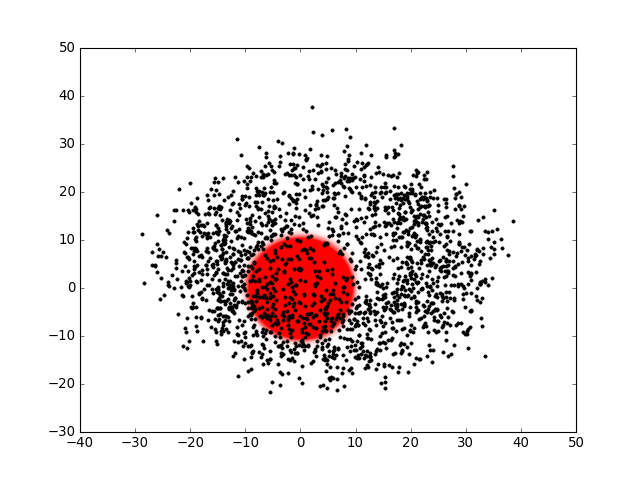

In [13]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

In [14]:
check_all_identities()
model['n_data'].set_value(n_samples)

In [15]:
from schlichtanders.myfunctools import compose_fmap, Average

In [16]:
def weights_data():
    for t in xrange(10000):
        yield min(1, 0.01 + t/10000)
    while True:
        yield 1
postmap = compose(post.flat_numericalize_postmap, post.normalizingflow_postmap)
optimizer_kwargs = postmap(model,
    mapreduce=compose_fmap(meanmap, Average(5)),
    annealing_combiner=post.AnnealingCombiner(weights_data=weights_data())
)
climin_kwargs = post.climin_postmap(optimizer_kwargs)
climin_kwargs

{'f': <function theano_models.postmaps.annealed>,
 'fprime': <function theano_models.postmaps.annealed>,
 'wrt': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.54132485,
         1.85458654,  0.54132485,  0.54132485])}

In [18]:
from theano_models.visualization import d3viz
from IPython.display import IFrame

In [19]:
d3viz(optimizer_kwargs['loss'], "tmp/loss.html")
IFrame("tmp/loss.html", width=700, height=500)

In [ ]:
batch_size = 20
n_batches = len(targets) // batch_size
climin_args = izip( imap(lambda x:(x,),  chunk(20, cycle(targets)) ) , repeat({}))

In [ ]:
opt = optimizer(
    identifier="rmsprop",
    step_rate=0.5,
    momentum=0.9,
    args=climin_args,
    **climin_kwargs
)

In [ ]:
for info in opt:  #every(n_batches, opt):
    print zip(model['flat'].name.split(':'), climin_kwargs['fprime'](opt.wrt, targets[:100]))
    plot_fit(fig, ax, {model['flat']:opt.wrt}, time_delay=None)

In [ ]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}, time_delay=None),
    **scipy_kwargs
); fit